#### Setup
The libraries are imported and the data is imported, setup, split, and preprocessed using the same process as in the previous notebook: Gerber Capstone (Part 1).

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer, WordNetLemmatizer 
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score,f1_score, classification_report
import eli5
#from eli5.lime import TextExplainer
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.multiclass import OneVsRestClassifier

In [2]:
tweets = pd.read_csv("Tweets.csv")

In [3]:
#Data Setup
#only keeping the airline sentiment and text columns
columns_to_keep = ['airline_sentiment', 'text']
tweets = tweets[columns_to_keep]


#numerically representing the contents of "airline_sentiment" column
tweets.replace({"positive" : 1, "neutral" : 0, "negative" : -1}, inplace = True)
tweets.head()

,airline_sentiment,text
0,0,@VirginAmerica What @dhepburn said.
1,1,@VirginAmerica plus you've added commercials t...
2,0,@VirginAmerica I didn't today... Must mean I n...
3,-1,@VirginAmerica it's really aggressive to blast...
4,-1,@VirginAmerica and it's a really big bad thing...


In [4]:
#Train/Test Split
X = tweets['text']
y = tweets['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [5]:
# Test Preprocessing
# Tokenization, stop word removal, punctuation removal, lower casing, and stemming
def preprocess_text(text):
    tokenizer = TweetTokenizer(preserve_case=False)
    swords = set(stopwords.words('english'))
    punc = set(string.punctuation)
    stemmer = PorterStemmer()

    preprocessed_text = []
    for entry in text:
        tokens = tokenizer.tokenize(entry)
        preprocessed_text.append([stemmer.stem(word) for word in tokens if word not in swords and word not in punc and not word.startswith('@')])
    return preprocessed_text

In [6]:
#preprocessing
pX_train = preprocess_text(X_train)
pX_train = [' '.join(x) for x in pX_train]

pX_test = preprocess_text(X_test)
pX_test = [' '.join(x) for x in pX_test]

In [7]:
#Adding preprocessed text column to the dataframe
tweets['processed_text'] = preprocess_text(X)

In [8]:
tweets.head(10)

,airline_sentiment,text,processed_text
0,0,@VirginAmerica What @dhepburn said.,[said]
1,1,@VirginAmerica plus you've added commercials t...,"[plu, ad, commerci, experi, ..., tacki]"
2,0,@VirginAmerica I didn't today... Must mean I n...,"[today, ..., must, mean, need, take, anoth, trip]"
3,-1,@VirginAmerica it's really aggressive to blast...,"[realli, aggress, blast, obnoxi, entertain, gu..."
4,-1,@VirginAmerica and it's a really big bad thing...,"[realli, big, bad, thing]"
5,-1,@VirginAmerica seriously would pay $30 a fligh...,"[serious, would, pay, 30, flight, seat, play, ..."
6,1,"@VirginAmerica yes, nearly every time I fly VX...","[ye, nearli, everi, time, fli, vx, “, ear, wor..."
7,0,@VirginAmerica Really missed a prime opportuni...,"[realli, miss, prime, opportun, men, without, ..."
8,1,"@virginamerica Well, I didn't…but NOW I DO! :-D","[well, …, :-d]"
9,1,"@VirginAmerica it was amazing, and arrived an ...","[amaz, arriv, hour, earli, good]"


### Model Evaluation
I refit the model using SVC which is the optimal model based on prior analysis in the previous notebook.

In [9]:
#re-fitting model
vec = TfidfVectorizer()
svc = SVC(kernel = 'linear', probability = True, C = 1)

svc_pipe = Pipeline([('tfidf', vec), ('svc', svc)]).fit(pX_train, y_train)

#### Model Statistics
- Accuracy: 0.79
- Precision: 0.78
- Recall: 0.79
- F1-score: 0.78

In [62]:
y_pred = svc_pipe.predict(pX_test)
print(classification_report(y_test, y_pred))
print("Accuracy: {:0.4}".format(accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

          -1       0.82      0.92      0.87      2340
           0       0.65      0.48      0.55       738
           1       0.79      0.65      0.71       582

    accuracy                           0.79      3660
   macro avg       0.75      0.68      0.71      3660
weighted avg       0.78      0.79      0.78      3660

Accuracy: 0.7913


#### Model Testing
I test this model by using it to predict the sentiment of Tweets by passing in the text of a single entry from the data, then comparing the model's predicted class and the actual class. This model correctly predicts the sentiments of these three data points, which are respectively negative, neutral, and positive. Shown below are three un-preprocessed Tweets text. 

Note: the model's predictions will be based on the preprocessed counterpart, or the pX column. 

Classes:
- -1 = negative sentiment
- 0 = neutral sentiment
- 1 = positve sentiment

##### Example of a Tweet with Negative Sentiment

In [63]:
#Prediction of a Negative Sentiment 
y_pred0 = svc_pipe.predict(pX_test)[1]
print(f'Predicted class: {y_pred0} \nActual class: {y_test.iloc[1]} \nPost: {X_test.iloc[1]}')

Predicted class: -1 
Actual class: -1 
Post: @USAirways how is it that my flt to EWR was Cancelled Flightled yet flts to NYC from USAirways are still flying?


##### Example of a Tweet with Neutral Sentiment

In [13]:
#Prediction of a Neutral Sentiment 
y_pred0 = svc_pipe.predict(pX_test)[3]
print(f'Predicted class: {y_pred0} \nActual class: {y_test.iloc[3]} \nPost: {X_test.iloc[3]}')

Predicted class: 0 
Actual class: 0 
Post: @JetBlue do they have to depart from Washington, D.C.??


##### Example of a Tweet with Positive Sentiment

In [25]:
#Prediction of a Positive Sentiment 
y_pred0 = svc_pipe.predict(pX_test)[9]
print(f'Predicted class: {y_pred0} \nActual class: {y_test.iloc[9]} \nPost: {X_test.iloc[9]}')

Predicted class: 1 
Actual class: 1 
Post: @usairways great crew for flight 504 PHX to YVR tonight! Friendly, efficient. Awesome job.


#### Confusion Matrix for SVC Model

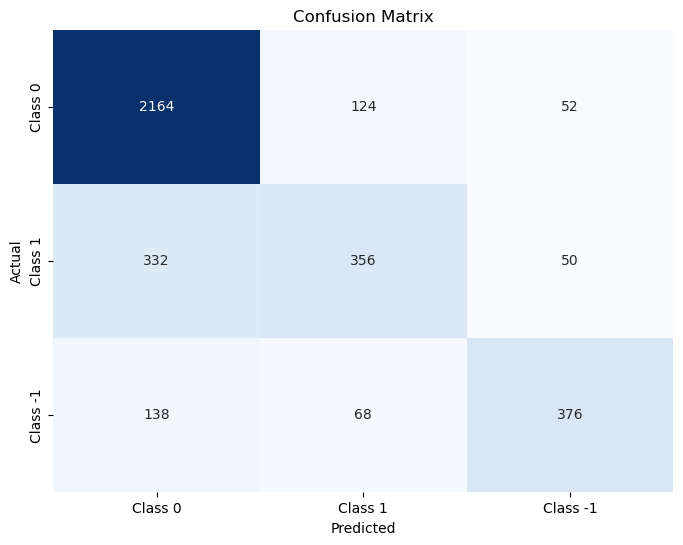

In [15]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, svc_pipe.predict(pX_test))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1', 'Class -1'],
            yticklabels=['Class 0', 'Class 1', 'Class -1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Extract values from the confusion matrix
correctly_predicted = np.trace(conf_matrix)
misclassified = np.sum(conf_matrix) - correctly_predicted
correctly_predicted_per_class = np.diag(conf_matrix)

print(f"Number of correctly predicted instances: {correctly_predicted}")
print(f"Number of mispredicted instances: {misclassified}")
print(f"Accuracy: {accuracy:.4f}")
print("Number of correctly predicted instances per class:")
for i, count in enumerate(correctly_predicted_per_class):
    print(f"Class {i}: {count}")

Number of correctly predicted instances: 2896
Number of mispredicted instances: 764
Accuracy: 0.7913
Number of correctly predicted instances per class:
Class 0: 2164
Class 1: 356
Class 2: 376


In [71]:
# Collecting preprocessed words from the posts of both classes
positive_words = tweets.query('airline_sentiment == 1')['processed_text'].values
neutral_words = tweets.query('airline_sentiment == 0')['processed_text'].values
negative_words = tweets.query('airline_sentiment == -1')['processed_text'].values

# Flattening the list of lists
positive_words = [word for sublist in positive_words for word in sublist]
neutral_words = [word for sublist in neutral_words for word in sublist]
negative_words = [word for sublist in negative_words for word in sublist]
all_words = positive_words + neutral_words + negative_words

# Calculate average word length
average_length_positive = sum(len(word) for word in positive_words) / len(positive_words)
average_length_neutral = sum(len(word) for word in neutral_words) / len(neutral_words)
average_length_negative = sum(len(word) for word in negative_words) / len(negative_words)
average_length_all = (average_length_positive + average_length_neutral + average_length_negative)/3

# Print the lengths 
print(f"Positive words length: {len(positive_words)}")
print(f"Neutral words length: {len(neutral_words)}")
print(f"Negative words length: {len(negative_words)}")
print(f"All words length: {len(all_words)}")

# Print the average word lengths
print(f"Average word length for Positive sentiment: {average_length_positive:.2f}")
print(f"Average word length for Neutral sentiment: {average_length_neutral:.2f}")
print(f"Average word length for Negative sentiment: {average_length_negative:.2f}")
print(f"Average word length for all sentiments: {average_length_all:.2f}")

Positive words length: 18531
Neutral words length: 23870
Negative words length: 96093
All words length: 138494
Average word length for Positive sentiment: 5.00
Average word length for Neutral sentiment: 5.20
Average word length for Negative sentiment: 4.85
Average word length for all sentiments: 5.02


#### Visualizing Common Words Through Word Clouds
Word Clouds can help us visualize the most common words used in each sentiment.

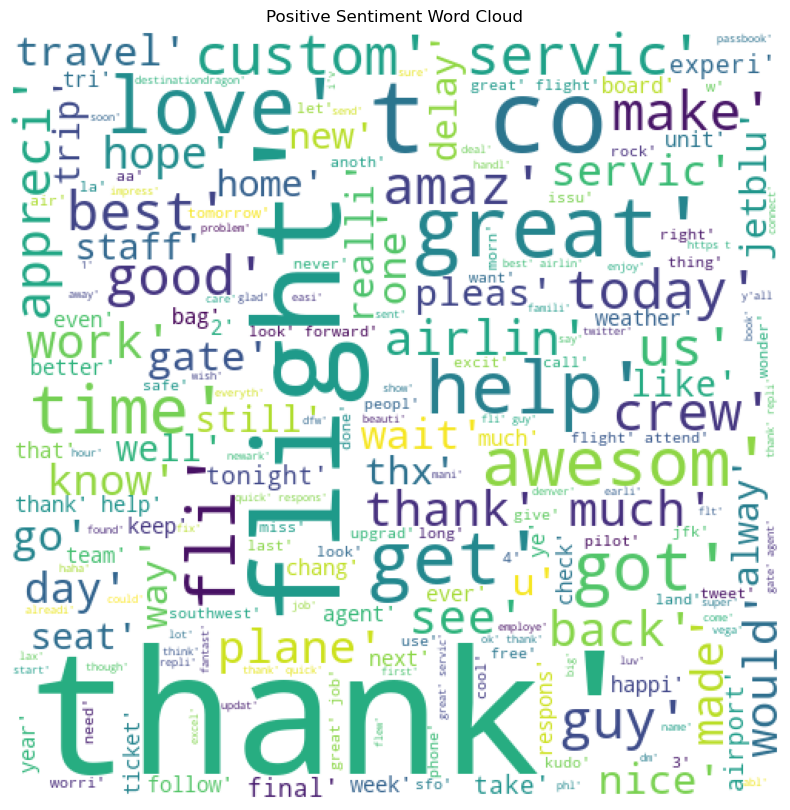

In [18]:
#Positive sentiment word cloud 
pos_wordcloud = WordCloud(width = 500, height = 500, stopwords = STOPWORDS, background_color = 'white').generate_from_text(str(positive_words))
plt.figure(figsize = (10, 10))
plt.imshow(pos_wordcloud)
plt.axis('off')
plt.title("Positive Sentiment Word Cloud", fontsize = 12)
plt.show()

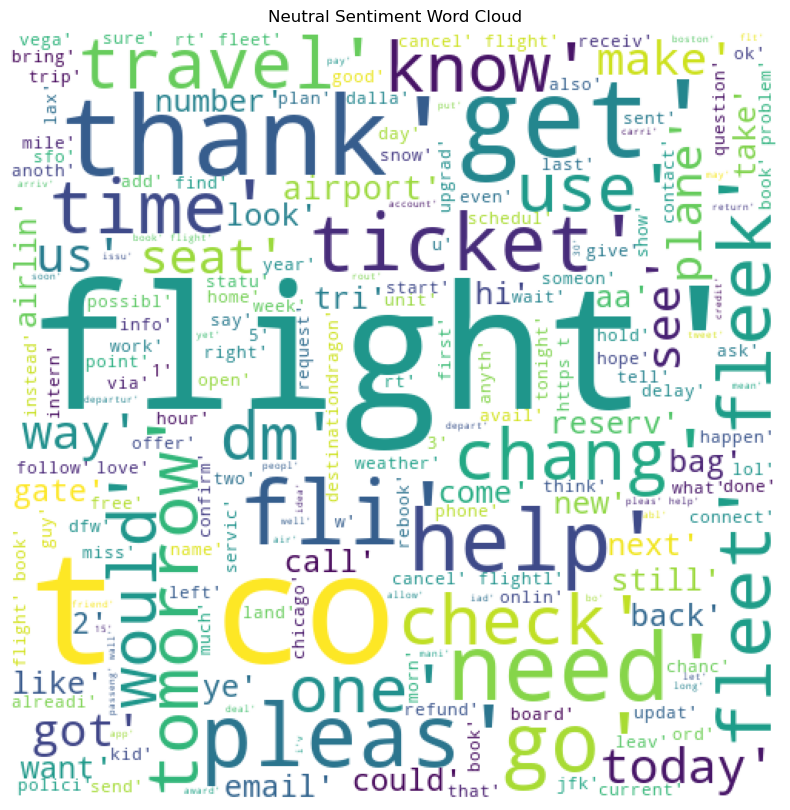

In [19]:
#Neutral sentiment word cloud 
neutral_wordcloud = WordCloud(width = 500, height = 500, stopwords = STOPWORDS, background_color = 'white').generate_from_text(str(neutral_words))
plt.figure(figsize = (10, 10))
plt.imshow(neutral_wordcloud)
plt.axis('off')
plt.title("Neutral Sentiment Word Cloud", fontsize = 12)
plt.show()

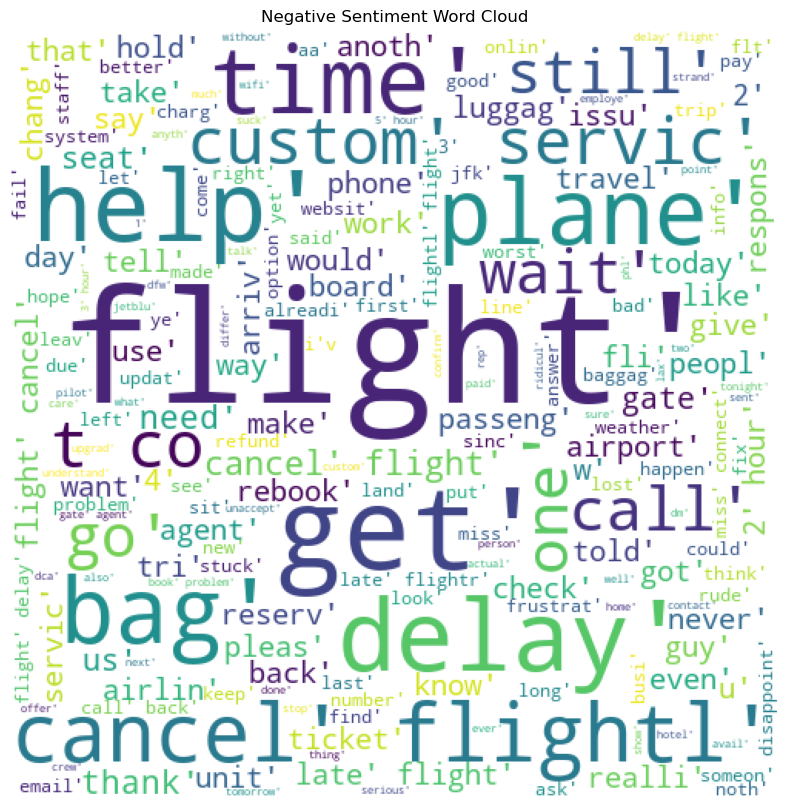

In [20]:
#Negative sentiment word cloud 
neg_wordcloud = WordCloud(width = 500, height = 500, stopwords = STOPWORDS, background_color = 'white').generate_from_text(str(negative_words))
plt.figure(figsize = (10, 10))
plt.imshow(neg_wordcloud)
plt.axis('off')
plt.title("Negative Sentiment Word Cloud", fontsize = 12)
plt.show()

#### Identify the 20 Most Common Words for Each Sentiment

In [57]:
# Create a CountVectorizer
vectorizer = CountVectorizer(stop_words='english')

# Create a list to store the top words for each sentiment
top_words_list = []

# Iterate over unique sentiment values
for sentiment in tweets['airline_sentiment'].unique():
    # Filter the DataFrame for each sentiment
    sentiment_df = tweets[tweets['airline_sentiment'] == sentiment].copy()
    
    # Convert the processed_text column from lists to strings
    sentiment_df['processed_text'] = sentiment_df['processed_text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
    
    # Fit and transform the CountVectorizer on the processed_text for the current sentiment
    X = vectorizer.fit_transform(sentiment_df['processed_text'])
    
    # Get the feature names (words)
    feature_names = vectorizer.get_feature_names_out()
    
    # Sum the counts for each word across all documents
    word_counts = X.sum(axis=0).A1
    
    # Create a DataFrame to store word counts and sort by count
    word_counts_df = pd.DataFrame({'word': feature_names, 'count': word_counts})
    word_counts_df = word_counts_df.sort_values(by='count', ascending=False)
    
    # Get the top 20 words
    top_words = word_counts_df.head(20)['word'].tolist()
    
    # Append the top words to the list
    top_words_list.append({'airline_sentiment': sentiment, 'top_words': top_words})
    
    # Print the result for the current sentiment
    print(f"Top 20 words for sentiment {sentiment}:", top_words)

# Create a DataFrame from the list of top words
top_words_df = pd.DataFrame(top_words_list)


Top 20 words for sentiment 0: ['flight', 'http', 'thank', 'need', 'pleas', 'help', 'fli', 'dm', 'book', 'ticket', 'chang', 'tomorrow', 'time', 'travel', 'fleek', 'check', 'know', 'fleet', 'cancel', 'way']
Top 20 words for sentiment 1: ['thank', 'flight', 'great', 'http', 'love', 'servic', 'help', 'fli', 'custom', 'guy', 'good', 'time', 'airlin', 'best', 'awesom', 'got', 'make', 'work', 'appreci', 'today']
Top 20 words for sentiment -1: ['flight', 'hour', 'cancel', 'delay', 'custom', 'servic', 'time', 'help', 'wait', 'bag', 'hold', 'plane', 'tri', 'need', 'flightl', 'day', 'http', 'gate', 'fli', 'thank']


#### Find Overlapping Words Among the 20 Most Common Words for Each Sentiment
There are five words that appear in all three lists of the 20 most common words of each sentiment. 

Those words are:
- http
- fli
- flight
- thank
- time
- help

In [58]:
# Find the overlapping words
common_words = set.intersection(*top_words_df['top_words'].apply(set))

# Print the result
print("Common words across sentiments:", common_words)


Common words across sentiments: {'http', 'fli', 'flight', 'thank', 'time', 'help'}


#### Next Steps and Recommendations
It could be helpful to do a global analysis using the ELI5 and LIME libraries and a local analysis to determine model feature weights (both positive and negative). 

It would be useful to train more complex and advanced models to see if they could better predict the sentiments of Tweets, as the best model (SVC) has accuracy below 80%. It would be great to get accuracy above 95% if possible in the future. Ensemble methods, Recurrent Neural Networks, and Convolutional Neural Networks could lead to a better and more accurate models. 

Further exploration of the top words for each sentiment could be done with the other models built: Logistic Regression, Naive Bayes, and Decision Tree.

It could be interesting to look at words that only appear in top 20 lists for Tweets of each sentiment and create a list to easily predict future posts.